# **Import Lib**

In [2]:
from PIL import Image
import torch
import depth_pro
import os
import numpy as np
# Lưu theo format depth-pro
import depth_pro.utils as utils

# **Depth Pro Demo**

In [5]:

# Hàm để lấy device GPU nếu có
def get_torch_device() -> torch.device:
    """Get the Torch device."""
    device = torch.device("cuda:0")
    if torch.cuda.is_available() == False:
        print("No GPU found, using CPU.")
        device = torch.device("cpu")
    elif torch.backends.mps.is_available():  # Cho MacOS với Apple Silicon
        device = torch.device("mps")
    return device

# Load model và preprocessing transform với GPU
device = get_torch_device()
model, transform = depth_pro.create_model_and_transforms(
    device=device,
    precision=torch.half  # Sử dụng half precision để tiết kiệm VRAM
)
model.eval()  # Chuyển model sang chế độ đánh giá
print("Model loaded successfully.")
print(f"Using device: {device}")


Model loaded successfully.
Using device: cuda:0


In [15]:
img_dir = "./img/"
image_name = "image-5.png"  # Tên file ảnh cần dự đoán
image_path = img_dir + image_name
# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

In [16]:

output_path = "output/"
os.makedirs(output_path, exist_ok=True)

# Lưu depth map
depth_output = os.path.join(output_path, image_name + ".npy")
np.save(depth_output, depth.cpu().numpy())

# Lưu focal length
focal_output = os.path.join(output_path, image_name+ "_focal_length.txt")
with open(focal_output, "w") as f:
    f.write(f"{focallength_px}")

print(f"Results saved to {output_path}")

Results saved to output/


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Đọc file
depth = np.load(depth_output)

# Xem thông tin cơ bản
print(f"Shape: {depth.shape}")
print(f"Data type: {depth.dtype}")
print(f"Min value: {depth.min()}")
print(f"Max value: {depth.max()}")
print(f"Mean value: {depth.mean()}")

Shape: (1637, 2400)
Data type: float32
Min value: 0.6878949999809265
Max value: 5.508957386016846
Mean value: 2.790462017059326


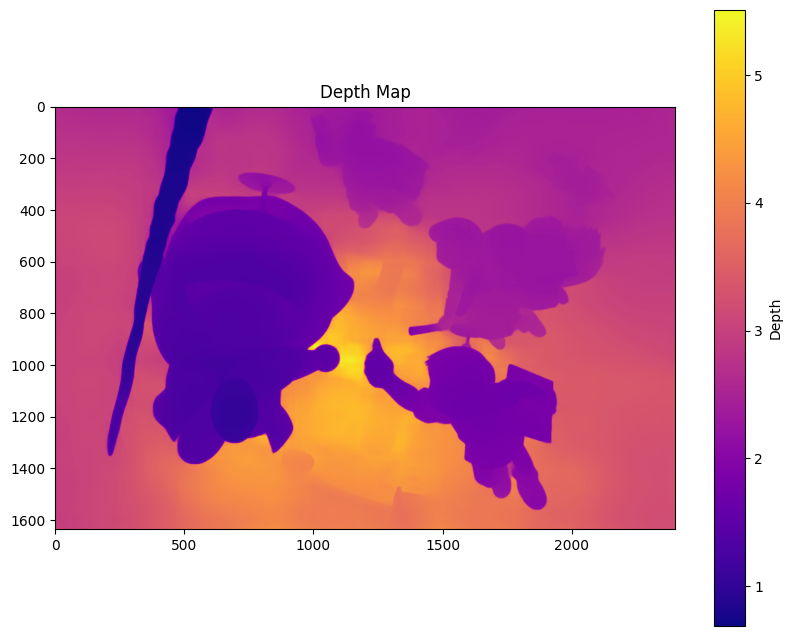

In [18]:
# Hiển thị và lưu depth map
plt.figure(figsize=(10, 8))
plt.imshow(depth, cmap='plasma')
plt.colorbar(label='Depth')
plt.title('Depth Map')

# Lưu hình trước khi hiển thị
plt.savefig(output_path + image_name + '_depth_map.png')

# Hiển thị sau khi đã lưu
plt.show()


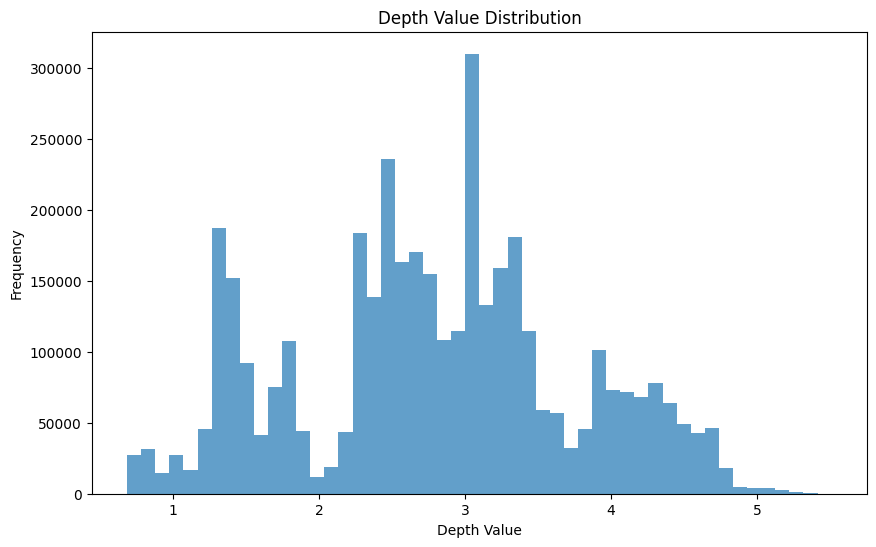

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(depth.flatten(), bins=50, alpha=0.7)
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.title('Depth Value Distribution')
plt.show()